#**FINAL PROJECT HOSE CLASSIFIER**

>**ESPECIALIZACIÓN EN INTELIGENCIA ARTIFICIAL**

Machine Learning 

> **Members**:

Daniela Gomez Ayalde.

Roberto Jose Guerrero Criollo.

Manuel Alejandro Henao Ramírez.

Stiven Ferney Quintero Diaz

> **E-mail**:

daniela.gomez_ayalde@uao.edu.co 

roberto.guerrero@uao.edu.co 

manuel.henao@uao.edu.co

stiven.quintero@uao.edu.co

> **Tutor:** Jose Luis Paniagua

####Universidad Autónoma de Occidente

## **Import Libraries**

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import interp
from itertools import cycle
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.layers import  Convolution2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, auc
from tensorflow.keras.applications.imagenet_utils import preprocess_input

!pip install -q -U keras-tuner
from google.colab import drive
drive.mount('/content/drive/', force_remount=True) 

import keras_tuner as kt

tf.random.set_seed(1234)

Mounted at /content/drive/


## **Dataset Segmentation**

In [3]:
import os
import math
import random
import shutil
from google.colab import drive
drive.mount('/content/drive/', force_remount=True) 
dir="/content/drive/MyDrive/ConstruPlast-Proyecto-Calidad/scripts/model"
os.chdir(dir)
names = ["SWAN_0", "SWAN_1", "GAS_0", "GAS_1","BACKGROUND"] # "BICOLOR_0", "BICOLOR_1", "PRESION_0", "PRESION_1"

# Reorganize the folder structure:
if not os.path.isdir(dir + '/train/'):
    for name in names:
        os.makedirs(dir + '/train/' + name)
        os.makedirs(dir + '/val/' + name)
        os.makedirs(dir + '/test/' + name)

 # Moce the image files
orig_folders = ["/SWAN_0/", "/SWAN_1/", "/GAS_0/", "/GAS_1/", "/BACKGROUND/"] #  "/BICOLOR_0/", "/BICOLOR_1/", "/PRESION_0/", "/PRESION_1/"
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(dir + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * 0.7) + 0.5)
    n_valid = int((number_of_images*0.25) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = dir + folder + file
        if idx < n_train:
            shutil.move(file_name, dir + "/train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, dir + "/val/" + names[folder_idx])
        else:
            shutil.move(file_name, dir + "/test/" + names[folder_idx])       

Mounted at /content/drive/
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0


## **Data Augmentation (increase in the number of images)**

Since we are working with a very small data set, it is especially important that we augment our data. We will make small modifications to the existing images, which will allow the model to see a wider variety of images to learn from. This will help it learn to recognize new hose section images rather than just memorizing the images it is trained on.

In [4]:
data_entrenamiento = '/content/drive/MyDrive/ConstruPlast-Proyecto-Calidad/scripts/model/train'
data_validacion = '/content/drive/MyDrive/ConstruPlast-Proyecto-Calidad/scripts/model/test'

#A data generator is created.
datagen_train = ImageDataGenerator(
    rescale = 1. / 255,               #Normalization of images.
    samplewise_center = False,        #Set the average of each sample.
    horizontal_flip = True,           #Horizontal flip the images randomly.
    vertical_flip = False             #Vertical flip the images randomly.
) 

#It is not necessary to increase the validation data.
datagen_valid = ImageDataGenerator(
    rescale = 1. / 255,
    samplewise_center = False 
    )

## **Upload dataset**

Images will be loaded directly from the folders using the [`flow_from_directory`](https://keras.io/api/preprocessing/image/) function of Keras. We have configured our directories to help this process run smoothly, as our labels are inferred from the folder names.

In [5]:
lenght = 224 
height = 224 
names = ["SWAN_1", "SWAN_0", "GAS_1", "GAS_0","BACKGROUND"]

#Load and iterate the training data set
train_it = datagen_train.flow_from_directory(
    data_entrenamiento,
    target_size = (lenght, height),
    class_mode = "categorical",
    color_mode = "rgb",
    batch_size = 8,
)

#Load and iterate the validation data set
valid_it = datagen_valid.flow_from_directory(
    data_validacion,
    target_size = (lenght, height),
    class_mode = "categorical",
    color_mode = "rgb",
    batch_size = 8,
    shuffle = False,
)

#Load and iterate the validation data set
# valid_full_dataset = datagen_valid.flow_from_directory(
#     data_validacion,
#     target_size = (lenght, height),
#     class_mode = "categorical",
#     color_mode = "rgb",
#     batch_size = 600,
#     shuffle = False,
#)

Found 1750 images belonging to 5 classes.
Found 125 images belonging to 5 classes.


## **Display dataset**

In [ ]:
src_path = "/content/drive/MyDrive/ConstruPlast-Proyecto-Calidad/scripts/model/train"
sub_class = os.listdir(src_path)

fig = plt.figure(figsize = (15,8))

path = os.path.join(src_path, sub_class[0])
for i in range(6):
    plt.subplot(4, 6, i+1)
    img = plt.imread(os.path.join(path, sub_class[0] + '_' + str(i) + '.jpg'))
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(sub_class[0])

path = os.path.join(src_path, sub_class[1])
for i in range(6,12):
    plt.subplot(4, 6, i+1)
    img = plt.imread(os.path.join(path, sub_class[1] + '_' + str(i) + '.jpg'))
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(sub_class[1])

path = os.path.join(src_path,sub_class[2])
for i in range(12,18):
    plt.subplot(4, 6, i+1)
    img = plt.imread(os.path.join(path, sub_class[2] + '_' + str(i) + '.jpg'))
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(sub_class[2])

path = os.path.join(src_path,sub_class[3])
for i in range(18,24):
    plt.subplot(4, 6, i+1)
    img = plt.imread(os.path.join(path, sub_class[3] + '_' + str(i) + '.jpg'))
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(sub_class[3])

path = os.path.join(src_path,sub_class[4])
for i in range(18,24):
    plt.subplot(4, 6, i+1)
    img = plt.imread(os.path.join(path, sub_class[4] + '_' + str(i) + '.jpg'))
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(sub_class[4])

Based on pre-trained models from the [Imagenet dataset](https://keras.io/api/applications/) and the [TensorFlow Hub](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/image_classification.ipynb) repository for the computational vision application. For hose fault classification, ***ResNet50V2*** , ***MobilNetV2*** and ***DenseNet169*** architectures were considered as alternatives to be implemented in the embedded system.

## **Classifier based on Deep Learning MobileNetV2**

### **Download pre-trained model**

In [6]:
modelo = 'MobileNetV2' 
lenght = 224 
height = 224 
base_model = applications.MobileNetV2(
    weights = 'imagenet',               #Loading of pre-trained model weights with ImageNet.
    input_shape = (lenght, height, 3),
    include_top = False)

9406464/9406464 [==============================] - 0s 0us/step


In [7]:
base_model.trainable = False    #Freeze the pre-trained layers of the model.
base_model.summary()            #Pre-training model summary  

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

### **Add top layer with 4-class classifier and model compilation**


Once the architecture of the pre-trained model is selected, an upper layer will be added to make the classification of the application case considering the previous extraction of characteristics, allowing a classification of the four classes of hoses that are produced in the company ConstruPlast (Swan-Bicolor-Presion-Gas) and if they present any production failure.

In [9]:
def model_builder_MobileNet(hp):
  clases = 5 
  inputs = tf.keras.Input(shape=(lenght, height, 3))     #RGB image inputs
  x = base_model(inputs, training = False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  
  outputs = tf.keras.layers.Dense(clases, activation='softmax')(x)
  model = tf.keras.Model(inputs, outputs)
  
  hp_loss = hp.Choice('loss', values=['categorical_crossentropy'])#, 'mean_squared_error', 'mean_squared_logarithmic_error'
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])

  # Select optimizer    
  optimizer = hp.Choice('optimizer', values=['adam']) #, 'SGD', 'adamax', 'nadam'

  # Conditional for each optimizer
  if optimizer == 'adam':
    hp_optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
  elif optimizer == 'SGD':
    hp_optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
  elif optimizer == 'adamax':
    hp_optimizer = tf.keras.optimizers.Adamax(learning_rate=hp_learning_rate)
  else:
    hp_optimizer = tf.keras.optimizers.Nadam(learning_rate=hp_learning_rate)

  model.summary()
  model.compile(loss = hp_loss, 
                optimizer = hp_optimizer, 
                metrics=['accuracy'])
  
  return model

In [10]:
tuner = kt.Hyperband(model_builder_MobileNet,
                     objective='accuracy',
                     max_epochs=10,
                     directory='dir_MobileNet',
                     project_name='MobileNet')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [12]:
tuner.search(train_it, epochs=50, callbacks=[stop_early])

Trial 30 Complete [00h 02m 11s]
accuracy: 0.8091428279876709

Best accuracy So Far: 1.0
Total elapsed time: 00h 34m 11s


In [13]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [14]:
print(best_hps.values)

{'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'optimizer': 'nadam', 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}


In [15]:
 data=pd.DataFrame([best_hps.values])
 data

,loss,learning_rate,optimizer,tuner/epochs,tuner/initial_epoch,tuner/bracket,tuner/round
0,categorical_crossentropy,0.001,nadam,2,0,2,0


### **Model training**

In [16]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_it, steps_per_epoch=20, validation_data = valid_it, validation_steps=8, epochs=20, verbose=1, callbacks=[stop_early])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/20
20/20 [===========================

In [17]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.069977,0.656250,0.468962,0.875
1,0.286665,0.943750,0.085616,1.000
2,0.140926,0.974684,0.040171,1.000
3,0.076254,0.993750,0.033503,1.000
4,0.102020,0.981250,0.026320,1.000
5,0.066990,0.987500,0.020649,1.000
6,0.039613,1.000000,0.013601,1.000
7,0.044150,0.993750,0.012284,1.000
8,0.037002,0.993750,0.010557,1.000
9,0.027339,1.000000,0.008416,1.000


In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

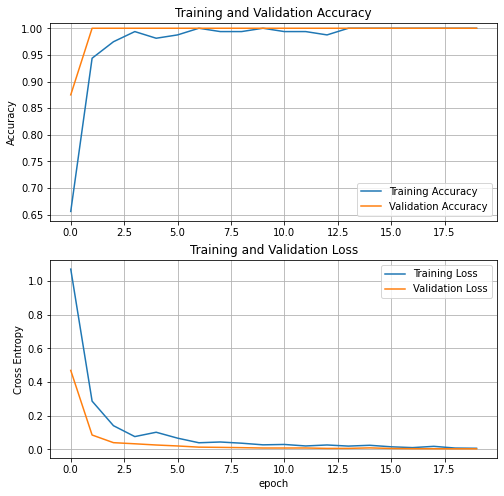

In [19]:
#Accuracy is plotted.
plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1.01])
plt.grid(True)
plt.title('Training and Validation Accuracy')

#The loss is plotted.
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

### **Results review**

With the results obtained we have the classifier for fault detection, we proceed to verify the model accuracy metric, which will indicate the efficiency of the model for the given task.

In [20]:
def make_predictions(test_image):
  imgplot = plt.imshow(test_image)
  test_image = img_to_array(test_image)
  test_image /= 255.
  result = model.predict(test_image.reshape(1, 224, 224,3))
  print(valid_it.class_indices)
  return result

1/1 [==============================] - 1s 1s/step
{'BACKGROUND': 0, 'GAS_0': 1, 'GAS_1': 2, 'SWAN_0': 3, 'SWAN_1': 4}


array([[9.9865037e-01, 8.9701825e-05, 8.4722630e-04, 2.0891853e-04,
        2.0382256e-04]], dtype=float32)

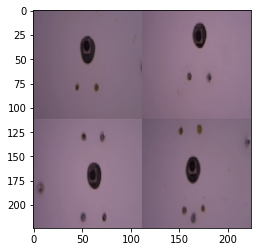

In [21]:
test_image = load_img('/content/drive/MyDrive/ConstruPlast-Proyecto-Calidad/scripts/model/val/BACKGROUND/BACKGROUND_350_.jpg', target_size=(224, 224))
make_predictions(test_image)

1/1 [==============================] - 0s 22ms/step
{'BACKGROUND': 0, 'GAS_0': 1, 'GAS_1': 2, 'SWAN_0': 3, 'SWAN_1': 4}


array([[1.0538401e-04, 9.9922609e-01, 2.1331036e-04, 2.5471396e-04,
        2.0042896e-04]], dtype=float32)

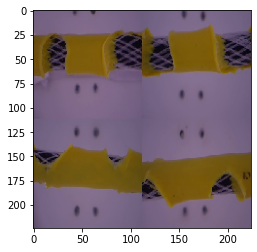

In [22]:
test_image1 = load_img('/content/drive/MyDrive/ConstruPlast-Proyecto-Calidad/scripts/model/val/GAS_0/GAS_0_350_.jpg', target_size=(224, 224))
make_predictions(test_image1)

1/1 [==============================] - 0s 29ms/step
{'BACKGROUND': 0, 'GAS_0': 1, 'GAS_1': 2, 'SWAN_0': 3, 'SWAN_1': 4}


array([[1.3384037e-03, 1.2938549e-03, 9.9646485e-01, 7.9381827e-04,
        1.0904570e-04]], dtype=float32)

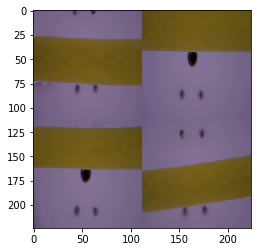

In [23]:
test_image2 = load_img('/content/drive/MyDrive/ConstruPlast-Proyecto-Calidad/scripts/model/val/GAS_1/GAS_1_154_.jpg', target_size=(224, 224))
make_predictions(test_image2)

1/1 [==============================] - 0s 22ms/step
{'BACKGROUND': 0, 'GAS_0': 1, 'GAS_1': 2, 'SWAN_0': 3, 'SWAN_1': 4}


array([[8.3229737e-05, 1.2464280e-03, 1.6349178e-03, 9.9654108e-01,
        4.9431890e-04]], dtype=float32)

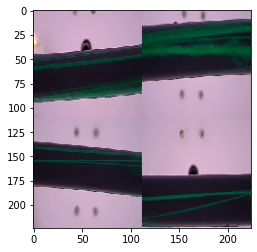

In [24]:
test_image3 = load_img('/content/drive/MyDrive/ConstruPlast-Proyecto-Calidad/scripts/model/val/SWAN_0/SWAN_0_115_.jpg', target_size=(224, 224))
make_predictions(test_image3)

1/1 [==============================] - 0s 20ms/step
{'BACKGROUND': 0, 'GAS_0': 1, 'GAS_1': 2, 'SWAN_0': 3, 'SWAN_1': 4}


array([[4.9796199e-07, 5.7181587e-05, 2.4946396e-06, 9.5320283e-04,
        9.9898666e-01]], dtype=float32)

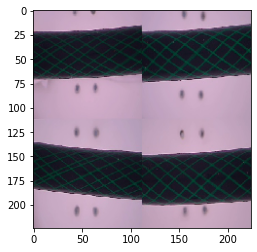

In [25]:
test_image4 = load_img('/content/drive/MyDrive/ConstruPlast-Proyecto-Calidad/scripts/model/val/SWAN_1/SWAN_1_341_.jpg', target_size=(224, 224))
make_predictions(test_image4)

### **Metrics for Model Evaluation**

In [26]:
target_dir = './redes/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
model.save('./redes/mobilnet.h5')
model.save_weights('./redes/mobilnet_pesos.h5')

In [27]:
loss_mobilnet, accuracy_mobilnet = model.evaluate_generator(valid_it)
print('Test loss MobilNetV2:', loss_mobilnet)
print('Test accuracy MobilNetV2:', accuracy_mobilnet)

<ipython-input-27-14c7ffcce4e3>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss_mobilnet, accuracy_mobilnet = model.evaluate_generator(valid_it)


Test loss MobilNetV2: 0.009115563705563545
Test accuracy MobilNetV2: 1.0


In [ ]:
# def plot_confusion_matrix(model, color):
#   num_of_test_samples = 600
#   batch_size = 8
#   Y_pred = model.predict_generator(valid_it, num_of_test_samples // batch_size+1)
#   y_pred = np.argmax(Y_pred, axis=1)

#   ConfusionMatrixDisplay.from_predictions(valid_it.classes, y_pred, cmap=color)
#   plt.show()
#   print('\nClassification Report:\n\n', classification_report(valid_it.classes, y_pred, target_names=valid_it.class_indices))

In [ ]:
# plot_confusion_matrix(model, color="Blues")

#### **Receiver operating characteristic curve (ROC)**

In [ ]:
# def plot_ROC(model):
#   imgs, labels = next(valid_full_dataset)
#   test_imgs, test_labels = next(valid_full_dataset)
#   rounded_labels = np.argmax(test_labels, axis=-1)
#   predictions = model.predict(valid_full_dataset, steps=1, verbose=0)
#   rounded_prediction = np.argmax(predictions, axis=-1)
#   # Plot linewidth.
#   lw = 1

#   # Compute ROC curve and ROC area for each class
#   fpr = dict()
#   tpr = dict()
#   roc_auc = dict()
#   for i in range(4):
#       fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
#       roc_auc[i] = auc(fpr[i], tpr[i])

#   # Compute micro-average ROC curve and ROC area
#   fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), predictions.ravel())
#   roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#   # Plot all ROC curves
#   plt.figure(1)
#   plt.plot(fpr["micro"], tpr["micro"],
#           label='ROC curve (AUC = {0:0.2f})'
#                 ''.format(roc_auc["micro"]),
#           color='deeppink', linestyle=':', linewidth=4)

#   colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#   for i, color in zip(range(4), colors):
#       plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#               label='ROC curve of class {0} (AUC = {1:0.2f})'
#               ''.format(i, roc_auc[i]))

#   plt.plot([0, 1], [0, 1], 'k--', lw=lw)
#   plt.xlim([-0.05, 1.0])
#   plt.ylim([0.0, 1.05])
#   plt.xlabel('False Positive Rate')
#   plt.ylabel('True Positive Rate')
#   plt.legend(loc="lower right")
#   plt.show()

In [ ]:
# plot_ROC(model)

## **Classifier based on Deep Learning ResNet50_V2**


### **Download pre-trained model**

In [28]:
modelo_ResNet = 'ResNet50V2' 
lenght = 224 
height = 224 
base_model_ResNet = applications.ResNet50V2(
    weights = 'imagenet',                       #Loading of pre-trained model weights with ImageNet.
    input_shape = (lenght, height, 3),
    include_top = False)

94668760/94668760 [==============================] - 0s 0us/step


In [29]:
base_model_ResNet.trainable = False    #Freeze the pre-trained layers of the model.
base_model_ResNet.summary()            #Pre-training model summary  

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

### **Add top layer with 4-class classifier and model compilation**

Once the architecture of the pre-trained model is selected, an upper layer will be added to make the classification of the application case considering the previous extraction of characteristics, allowing a classification of the four classes of hoses that are produced in the company ConstruPlast (Swan-Bicolor-Presion-Gas) and if they present any production failure.

In [30]:
def model_builder_ResNet(hp):
  clases = 5
  inputs_ResNet = tf.keras.Input(shape = (lenght, height, 3))   #RGB image inputs

  x_ResNet = base_model_ResNet(inputs_ResNet, training = False)
  x_ResNet = tf.keras.layers.GlobalAveragePooling2D()(x_ResNet)

  outputs_ResNet = tf.keras.layers.Dense(clases, activation = 'softmax')(x_ResNet)
  model_ResNet = tf.keras.Model(inputs_ResNet, outputs_ResNet)
  
  hp_loss = hp.Choice('loss', values=['categorical_crossentropy', 'mean_squared_error', 'mean_squared_logarithmic_error'])
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])

  # Select optimizer    
  optimizer = hp.Choice('optimizer', values=['adam', 'SGD', 'adamax', 'nadam'])

  # Conditional for each optimizer
  if optimizer == 'adam':
    hp_optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
  elif optimizer == 'SGD':
    hp_optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
  elif optimizer == 'adamax':
    hp_optimizer = tf.keras.optimizers.Adamax(learning_rate=hp_learning_rate)
  else:
    hp_optimizer = tf.keras.optimizers.Nadam(learning_rate=hp_learning_rate)

  model_ResNet.summary()
  model_ResNet.compile(loss = hp_loss, 
                optimizer = hp_optimizer, 
                metrics=['accuracy'])
  
  return model_ResNet

In [31]:
tuner_ResNet = kt.Hyperband(model_builder_ResNet,
                     objective='accuracy',
                     max_epochs=10,
                     directory='dir_ResNet',
                     project_name='ResNet')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23,575,045
Trainable params: 10,245
Non-trainable params: 23,564,800
_________________________________________________________________


In [32]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [33]:
tuner_ResNet.search(train_it, epochs=50, callbacks=[stop_early])

Trial 30 Complete [00h 02m 18s]
accuracy: 0.8634285926818848

Best accuracy So Far: 1.0
Total elapsed time: 00h 30m 41s


In [34]:
best_hps_ResNet = tuner_ResNet.get_best_hyperparameters(num_trials=1)[0]

In [35]:
print(best_hps_ResNet.values)

{'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'optimizer': 'nadam', 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}


### **Model training**

In [36]:
model_ResNet = tuner_ResNet.hypermodel.build(best_hps_ResNet)
history_ResNet = model_ResNet.fit(train_it, steps_per_epoch=20, validation_data = valid_it, validation_steps=8, epochs=20, verbose=1, callbacks=[stop_early])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23,575,045
Trainable params: 10,245
Non-trainable params: 23,564,800
_________________________________________________________________
Epoch 1/20
20/20 [==============================] - 6s 130ms/step - loss: 0.7463 - accuracy: 0.7188 - val_lo

In [37]:
pd.DataFrame(history_ResNet.history)

,loss,accuracy,val_loss,val_accuracy
0,0.746262,0.71875,0.164286,1.0
1,0.233272,0.94375,0.080710,1.0
2,0.199644,0.95625,0.037413,1.0
3,0.171173,0.94375,0.055592,1.0
4,0.133233,0.95625,0.026625,1.0
5,0.109710,0.96875,0.024208,1.0
6,0.080363,0.97500,0.016249,1.0
7,0.096000,0.97500,0.024443,1.0
8,0.069660,0.97500,0.017030,1.0
9,0.048357,1.00000,0.016629,1.0


In [38]:
acc_resnet = history_ResNet.history['accuracy']
val_acc_resnet = history_ResNet.history['val_accuracy']

loss_resnet = history_ResNet.history['loss']
val_loss_resnet = history_ResNet.history['val_loss']

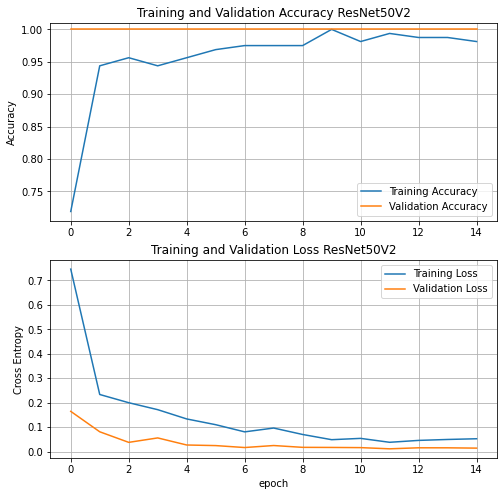

In [39]:
#Accuracy is plotted.
plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_resnet, label='Training Accuracy')
plt.plot(val_acc_resnet, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1.01])
plt.grid(True)
plt.title('Training and Validation Accuracy ResNet50V2')

#The loss is plotted.
plt.subplot(2, 1, 2)
plt.plot(loss_resnet, label='Training Loss')
plt.plot(val_loss_resnet, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss ResNet50V2')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

### **Results review**

With the results obtained we have the classifier for fault detection, we proceed to verify the model accuracy metric, which will indicate the efficiency of the model for the given task.

In [ ]:
def make_predictions_resnet(test_image):
  imgplot = plt.imshow(test_image)
  test_image = img_to_array(test_image)
  test_image /= 255.
  result = model_ResNet.predict(test_image.reshape(1, 224, 224,3))
  print(valid_it.class_indices)
  return result

1/1 [==============================] - 1s 1s/step
{'GAS_0': 0, 'GAS_1': 1, 'SWAN_0': 2, 'SWAN_1': 3}


array([[9.9891531e-01, 8.5072561e-06, 1.0640575e-03, 1.2166143e-05]],
      dtype=float32)

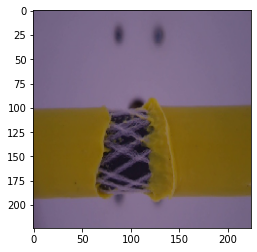

In [ ]:
test_image4 = load_img('/content/project_machinelearning/dataset/test/GAS_0/GAS_0_447.jpg', target_size=(224, 224))
make_predictions_resnet(test_image4)

1/1 [==============================] - 0s 24ms/step
{'GAS_0': 0, 'GAS_1': 1, 'SWAN_0': 2, 'SWAN_1': 3}


array([[2.4305062e-02, 9.7230351e-01, 2.8604404e-03, 5.3096039e-04]],
      dtype=float32)

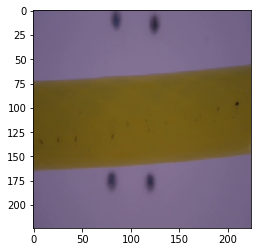

In [ ]:
test_image5 = load_img('/content/project_machinelearning/dataset/test/GAS_1/GAS_1_400.jpg', target_size=(224, 224))
make_predictions_resnet(test_image5)

1/1 [==============================] - 0s 26ms/step
{'GAS_0': 0, 'GAS_1': 1, 'SWAN_0': 2, 'SWAN_1': 3}


array([[6.7996082e-04, 5.7020911e-04, 1.0781154e-02, 9.8796868e-01]],
      dtype=float32)

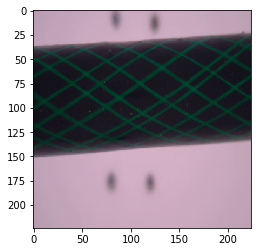

In [ ]:
test_image6 = load_img('/content/project_machinelearning/dataset/test/SWAN_1/SWAN_1_496.jpg', target_size=(224, 224))
make_predictions_resnet(test_image6)

1/1 [==============================] - 0s 28ms/step
{'GAS_0': 0, 'GAS_1': 1, 'SWAN_0': 2, 'SWAN_1': 3}


array([[5.7466732e-05, 4.5415716e-11, 9.9994254e-01, 2.4463159e-10]],
      dtype=float32)

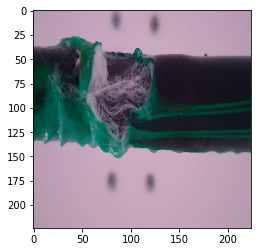

In [ ]:
test_image7 = load_img('/content/project_machinelearning/dataset/test/SWAN_0/SWAN_0_370.jpg', target_size=(224, 224))
make_predictions_resnet(test_image7)

### **Metrics for Model Evaluation**

In [41]:
target_dir = './redes/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
model_ResNet.save('./redes/resnet.h5')
model_ResNet.save_weights('./redes/resnet_pesos.h5')

In [ ]:
loss_resnet,accuracy_resnet = model_ResNet.evaluate_generator(valid_it)
print('Test loss:', loss_resnet)
print('Test accuracy:', accuracy_resnet)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test loss: 0.02913806028664112
Test accuracy: 0.9983333349227905


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


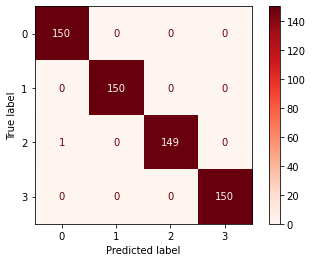


Classification Report:

               precision    recall  f1-score   support

       GAS_0       0.99      1.00      1.00       150
       GAS_1       1.00      1.00      1.00       150
      SWAN_0       1.00      0.99      1.00       150
      SWAN_1       1.00      1.00      1.00       150

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [ ]:
plot_confusion_matrix(model_ResNet, color="Reds")

#### **Receiver operating characteristic curve (ROC)**

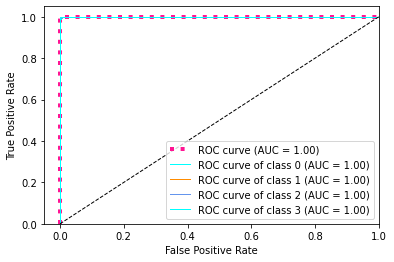

In [ ]:
plot_ROC(model_ResNet)

## **Classifier based on Deep Learning DenseNet169** 

### **Download pre-trained model**

In [ ]:
modelo_DenseNet = 'DenseNet169' 
lenght = 224 
height = 224 
base_model_DenseNet169 = applications.DenseNet169(
    weights = 'imagenet',                             #Loading of pre-trained model weights with ImageNet.
    input_shape = (lenght, height, 3),
    include_top = False)

51877672/51877672 [==============================] - 3s 0us/step


In [ ]:
base_model_DenseNet169.trainable = False     #Pre-trained layers of the model are frozen.
base_model_DenseNet169.summary()             #Pre-training model summary 

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

### **Add top layer with 4-class classifier and model compilation**


Once the architecture of the pre-trained model is selected, an upper layer will be added to make the classification of the application case considering the previous extraction of characteristics, allowing a classification of the four classes of hoses that are produced in the company ConstruPlast (Swan-Bicolor-Presion-Gas) and if they present any production failure.

In [ ]:
def model_builder_DenseNet(hp):
  clases = 4
  inputs_DenseNet169 = tf.keras.Input(shape=(lenght, height, 3))   #RGB image inputs

  x_DenseNet169 = base_model_DenseNet169(inputs_DenseNet169, training=False)
  x_DenseNet169 = tf.keras.layers.GlobalAveragePooling2D()(x_DenseNet169)

  outputs_DenseNet169 = tf.keras.layers.Dense(clases, activation='softmax')(x_DenseNet169)
  model_DenseNet = tf.keras.Model(inputs_DenseNet169, outputs_DenseNet169)
  
  hp_loss = hp.Choice('loss', values=['categorical_crossentropy', 'mean_squared_error', 'mean_squared_logarithmic_error'])
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])

  # Select optimizer    
  optimizer = hp.Choice('optimizer', values=['adam', 'SGD', 'adamax', 'nadam'])

  # Conditional for each optimizer
  if optimizer == 'adam':
    hp_optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
  elif optimizer == 'SGD':
    hp_optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
  elif optimizer == 'adamax':
    hp_optimizer = tf.keras.optimizers.Adamax(learning_rate=hp_learning_rate)
  else:
    hp_optimizer = tf.keras.optimizers.Nadam(learning_rate=hp_learning_rate)

  model_DenseNet.summary()
  model_DenseNet.compile(loss = hp_loss, 
                optimizer = hp_optimizer, 
                metrics=['accuracy'])
  
  return model_DenseNet

In [ ]:
tuner_DenseNet = kt.Hyperband(model_builder_DenseNet,
                     objective='accuracy',
                     max_epochs=10,
                     directory='dir_DenseNet',
                     project_name='DenseNet')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d_2   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 4)                 6660      
                                                                 
Total params: 12,649,540
Trainable params: 6,660
Non-trainable params: 12,642,880
_________________________________________________________________


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
tuner_DenseNet.search(train_it, epochs=50, callbacks=[stop_early])


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
mean_squared_error|?                 |loss
0.01              |?                 |learning_rate
adam              |?                 |optimizer
2                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
2                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                      

KeyboardInterrupt: ignored

In [ ]:
best_hps_DenseNet = tuner_DenseNet.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print(best_hps_DenseNet.values)

### **Model training**

In [ ]:
model_DenseNet = tuner_DenseNet.hypermodel.build(best_hps_ResNet)
history_DenseNet169 = model_DenseNet.fit(train_it, steps_per_epoch=20, validation_data = valid_it, validation_steps=8, epochs=20, verbose=1, callbacks=[stop_early])

In [ ]:
pd.DataFrame(history_DenseNet169.history)

In [ ]:
acc_densenet = history_DenseNet169.history['accuracy']
val_acc_densenet = history_DenseNet169.history['val_accuracy']

loss_densenet = history_DenseNet169.history['loss']
val_loss_densenet = history_DenseNet169.history['val_loss']

In [ ]:
#Accuracy is plotted.
plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_densenet, label = 'Training Accuracy')
plt.plot(val_acc_densenet, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1.01])
plt.grid(True)
plt.title('Training and Validation Accuracy DenseNet169')

#The loss is plotted.
plt.subplot(2, 1, 2)
plt.plot(loss_densenet, label = 'Training Loss')
plt.plot(val_loss_densenet, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss DenseNet169')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

### **Results review**

With the results obtained we have the classifier for fault detection, we proceed to verify the model accuracy metric, which will indicate the efficiency of the model for the given task.

In [ ]:
def make_predictions_densenet(test_image):
  imgplot = plt.imshow(test_image)
  test_image = img_to_array(test_image)
  test_image /= 255.
  result = model_DenseNet.predict(test_image.reshape(1, 224, 224,3))
  print(valid_it.class_indices)
  return result

In [ ]:
test_image8 = load_img('/content/project_machinelearning/dataset/test/GAS_0/GAS_0_408.jpg', target_size=(224, 224))
make_predictions_densenet(test_image8)

In [ ]:
test_image9 = load_img('/content/project_machinelearning/dataset/test/GAS_1/GAS_1_450.jpg', target_size=(224, 224))
make_predictions_densenet(test_image9)

In [ ]:
test_image10 = load_img('/content/project_machinelearning/dataset/test/SWAN_1/SWAN_1_353.jpg', target_size=(224, 224))
make_predictions_densenet(test_image10)

In [ ]:
test_image11 = load_img('/content/project_machinelearning/dataset/test/SWAN_0/SWAN_0_386.jpg', target_size=(224, 224))
make_predictions_densenet(test_image11)

### **Metrics for Model Evaluation**

In [ ]:
target_dir = './modelo/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
model_DenseNet.save('./modelo/densenet.h5')
model_DenseNet.save_weights('./modelo/densenet_pesos.h5')

In [ ]:
loss_densenet, accuracy_densenet = model_DenseNet.evaluate_generator(valid_it)
print('Test loss:', loss_densenet)
print('Test accuracy:', accuracy_densenet)

In [ ]:
plot_confusion_matrix(model_DenseNet, color="Purples")

#### **Receiver operating characteristic curve (ROC)**

In [ ]:
plot_ROC(model_DenseNet)

## **Fine-Tuning Technique (MobileNet)**

Now that the new model layers are trained, we have the option to apply one last trick to improve the model, called [fine-tuning](https://developers.google.com/machine-learning/glossary#f). To do this, we unfreeze the entire model and retrain it with a very small learning rate. This will cause the pre-trained base layers to take very small steps and be fine-tuned slightly, improving the model by a small amount.  

It is important to do this step only after the model with frozen layers has been fully trained. The untrained clustering and classification layers that we added to the model earlier were initialized randomly. This means that they had to be updated quite a bit to correctly classify the images. Through the process of [backpropagation](https://developers.google.com/machine-learning/glossary#backpropagation), the large initial updates in the latter layers would have caused large updates in the pre-trained layers as well. These updates would have destroyed those important pre-trained features. However, now that those final layers are trained and have converged, any updates to the model as a whole will be much smaller (especially with a very small learning rate) and will not destroy the features in the earlier layers.

In [ ]:
# Defrost the base model.
base_model.trainable = True
base_learning_rate = best_hps.values["learning_rate"]
learning_rate_reduction = 0.01

# Conditional for each optimizer
if best_hps.values["optimizer"] == 'adam':
  fine_opt_MobilNet = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*learning_rate_reduction)
elif best_hps.values["optimizer"] == 'SGD':
  fine_opt_MobilNet = tf.keras.optimizers.SGD(learning_rate=base_learning_rate*learning_rate_reduction)
elif best_hps.values["optimizer"] == 'adamax':
  fine_opt_MobilNet = tf.keras.optimizers.Adamax(learning_rate=base_learning_rate*learning_rate_reduction)
else:
  fine_opt_MobilNet = tf.keras.optimizers.Nadam(learning_rate=base_learning_rate*learning_rate_reduction)

model.compile(loss=best_hps.values["loss"], optimizer = fine_opt_MobilNet, metrics=['accuracy'])

In [ ]:
history_fine = model.fit(train_it, steps_per_epoch=30, validation_data = valid_it, validation_steps=10, initial_epoch=history.epoch[-1], epochs=20)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
#Accuracy is plotted
plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.plot([10-1, 10-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.grid(True)
plt.title('Training and Validation Accuracy MobilNetV2')

#The loss is plotted
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss ')
#plt.plot([10-1, 10-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss MobilNetV2')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

### **Metrics for Model Evaluation**

In [ ]:
loss_mobilnet, accuracy_mobilnet = model.evaluate_generator(valid_it)
print('Test loss MobilNetV2:', loss_mobilnet)
print('Test accuracy MobilNetV2:', accuracy_mobilnet)

In [ ]:
plot_confusion_matrix(model,color="Blues")

## **Fine-Tuning Technique (ResNet)**

In [ ]:
# Defrost the base model.
base_model_ResNet.trainable = True
base_learning_rate = best_hps_ResNet.values["learning_rate"]
learning_rate_reduction = 0.01 

# Conditional for each optimizer
if best_hps_ResNet.values["optimizer"] == 'adam':
  fine_opt_ResNet = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*learning_rate_reduction)
elif best_hps_ResNet.values["optimizer"] == 'SGD':
  fine_opt_ResNet = tf.keras.optimizers.SGD(learning_rate=base_learning_rate*learning_rate_reduction)
elif best_hps_ResNet.values["optimizer"] == 'adamax':
  fine_opt_ResNet = tf.keras.optimizers.Adamax(learning_rate=base_learning_rate*learning_rate_reduction)
else:
  fine_opt_ResNet = tf.keras.optimizers.Nadam(learning_rate=base_learning_rate*learning_rate_reduction)
  
model_ResNet.compile(loss = 'categorical_crossentropy', optimizer = fine_opt_ResNet, metrics=['accuracy'])

In [ ]:
history_fine_Res = model_ResNet.fit(train_it, steps_per_epoch = 30, validation_data = valid_it, validation_steps=10, initial_epoch = history_ResNet.epoch[-1], epochs=20)

In [ ]:
acc_resnet += history_fine_Res.history['accuracy']
val_acc_resnet += history_fine_Res.history['val_accuracy']

loss_resnet_1 = history_ResNet.history['loss'] + history_fine_Res.history['loss']
# loss_resnet_1 += history_fine_Res.history['loss']
val_loss_resnet += history_fine_Res.history['val_loss']

In [ ]:
#Accuracy is plotted
plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_resnet, label = 'Training Accuracy')
plt.plot(val_acc_resnet, label = 'Validation Accuracy')
#plt.plot([10-1, 10-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.grid(True)
plt.title('Training and Validation Accuracy Resnet50_V2')

#Loss is plotted
plt.subplot(2, 1, 2)
plt.plot(loss_resnet_1, label = 'Training Loss')
plt.plot(val_loss_resnet, label = 'Validation Loss')
#plt.plot([10-1, 10-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss Resnet50_V2')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

### **Metrics for Model Evaluation**


In [ ]:
loss_resnet, accuracy_resnet = model_ResNet.evaluate_generator(valid_it)
print('Test loss:', loss_resnet)
print('Test accuracy:', accuracy_resnet)

In [ ]:
plot_confusion_matrix(model_ResNet,color="Reds")

## **Fine-Tuning Technique (DenseNet)**

In [ ]:
# Defrost the base model.
base_model_DenseNet169.trainable = True
base_learning_rate = best_hps_DenseNet.values["learning_rate"]
learning_rate_reduction = 0.01 

# Conditional for each optimizer
if best_hps_DenseNet.values["optimizer"] == 'adam':
  fine_opt_DenseNet = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*learning_rate_reduction)
elif best_hps_DenseNet.values["optimizer"] == 'SGD':
  fine_opt_DenseNet = tf.keras.optimizers.SGD(learning_rate=base_learning_rate*learning_rate_reduction)
elif best_hps_DenseNet.values["optimizer"] == 'adamax':
  fine_opt_DenseNet = tf.keras.optimizers.Adamax(learning_rate=base_learning_rate*learning_rate_reduction)
else:
  fine_opt_DenseNet = tf.keras.optimizers.Nadam(learning_rate=base_learning_rate*learning_rate_reduction)

model_DenseNet.compile(loss = 'categorical_crossentropy', optimizer = fine_opt_DenseNet, metrics=['accuracy'])

In [ ]:
history_fine_DenseNet169 = model_DenseNet.fit(train_it, steps_per_epoch = 30, validation_data = valid_it, validation_steps = 10, initial_epoch = history_DenseNet169.epoch[-1], epochs=20)

In [ ]:
acc_densenet += history_fine_DenseNet169.history['accuracy']
val_acc_densenet += history_fine_DenseNet169.history['val_accuracy']

loss_densenet_1 = history_DenseNet169.history['loss'] + history_fine_DenseNet169.history['loss']
# loss_densenet += history_fine_DenseNet169.history['loss']
val_loss_densenet += history_fine_DenseNet169.history['val_loss']

In [ ]:
#Accuracy is plotted
plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_densenet, label = 'Training Accuracy')
plt.plot(val_acc_densenet, label = 'Validation Accuracy')
#plt.plot([10-1, 10-1], plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'lower right')
plt.grid(True)
plt.title('Training and Validation Accuracy DenseNet169')

#The loss is plotted.
plt.subplot(2, 1, 2)
plt.plot(loss_densenet_1, label = 'Training Loss')
plt.plot(val_loss_densenet, label = 'Validation Loss')
#plt.plot([10-1, 10-1], plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss DenseNet169')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

### **Metrics for Model Evaluation**

In [ ]:
loss_densenet, accuracy_densenet = model_DenseNet.evaluate_generator(valid_it)
print('Test loss:', loss_densenet)
print('Test accuracy:', accuracy_densenet)

In [ ]:
plot_confusion_matrix(model_DenseNet,color="Purples")